In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init

class Fire(nn.Module):
    """fire module for SqueezeNet"""
    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__() # same as super().__init__()?
        self.inplanes = inplanes
        self.squeeze = nn.Conv3d(inplanes, squeeze_planes, kernel_size=1) #1x1 convolution, inplanes = input feature maps, squeeze_planes = output feature maps
        self.squeeze_ReLU = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv3d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1) #1x1 convolution, squeeze_planes = input feature maps, expand1x1_planes = output feature maps
        self.expand1x1_ReLU = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv3d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1) #3x3 convolution, squeeze_planes = input feature maps, expand3x3_planes = output feature maps
        self.expand3x3_ReLU = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        method forward(input) returns output
        """
        x = self.squeeze_ReLU(self.squeeze(x)) #wrapping ReLU over output of 1x1 convolution squeeze layer
        return torch.cat([
            self.expand1x1_ReLU(self.expand1x1(x)),
            self.expand3x3_ReLU(self.expand3x3(x))
        ], 1) #concatenating output of expand layers (1x1 and 3x3 convolutions)


class SqueezeNet(nn.Module):

    def __init__(self, num_classes=1): #binary classification, so num_classes = 1
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
                nn.Conv3d(2, 96, kernel_size=7, stride=1), # 2 input channels (event_map, residue mask), 96 output channels, 7x7x7 kernel size, stride 2
                nn.ReLU(inplace=True), # inplace used to save memory
                nn.MaxPool3d(kernel_size=2, stride=2, ceil_mode=True), # 3x3x3 kernel size, stride 2, ceil_mode adds padding if necessary so that output size not reduced: https://stackoverflow.com/questions/59906456/in-pytorchs-maxpool2d-is-padding-added-depending-on-ceil-mode
                Fire(96, 16, 64, 64), # 96 input feature maps, squeeze layer squeezes input to 16 feature maps, 64+64=128 output feature maps (64 from 1x1 conv, 64 from 3x3 conv in expand layers)
                Fire(128, 16, 64, 64), # 128 input feature maps, 128 output feature maps
                Fire(128, 32, 128, 128), #128 input feature maps, 256 output feature maps
                nn.MaxPool3d(kernel_size=2, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128), #256 input feature maps, 256 output feature maps
                Fire(256, 48, 192, 192), #256 input feature maps, 384 output feature maps
                Fire(384, 48, 192, 192), #384 input feature maps, 384 output feature maps
                Fire(384, 64, 256, 256), #384 input feature maps, 512 output feature maps
                nn.MaxPool3d(kernel_size=2, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256), #512 input feature maps, 512 output feature maps
            )

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv3d(512, self.num_classes, kernel_size=1) #binary classification, so num_classes = 1, so only one output channel
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((1, 1, 1)) 
            #average pooling where hyperparameters (stride, kernel size) are automatically adjusted
            #only output size is specified — output size is (1, 1, 1, 1, 1) (N, C, D, W, H) in this case — i.e. one sample. one channel, 1x1x1 tensor/scalar
        )

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

        self.act = nn.Sigmoid() #sigmoid activation function for binary classifier

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3] * x.shape[4]) #reshapes tensor

        return self.act(x)

net = SqueezeNet()
print(net)

SqueezeNet(
  (features): Sequential(
    (0): Conv3d(2, 96, kernel_size=(7, 7, 7), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv3d(96, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (squeeze_ReLU): ReLU(inplace=True)
      (expand1x1): Conv3d(16, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (expand1x1_ReLU): ReLU(inplace=True)
      (expand3x3): Conv3d(16, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (expand3x3_ReLU): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv3d(128, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (squeeze_ReLU): ReLU(inplace=True)
      (expand1x1): Conv3d(16, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (expand1x1_ReLU): ReLU(inplace=True)
      (expand3x3): Conv3d(16, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (expand3x3_ReLU): ReLU(inplace=True)
    )
    (5

In [3]:
#https://www.learnpytorch.io/04_pytorch_custom_datasets/#7-model-0-tinyvgg-without-data-augmentation

#feed in single dataset to model and see what it outputs
from learning.torch_data_setup import *
import pathlib
from torch.utils.data import DataLoader

training_csv = pathlib.Path.cwd().parent / "training" / "training_set.csv"
training_dframe = pd.read_csv(training_csv)
training_dataset = ResidueDataset(residues_dframe=training_dframe, 
                                    transform=transforms.Compose([
                                        SamplingRandomRotations(translation_radius=0, random_rotation=False),
                                        ConcatEventResidueToTwoChannels(),
                                        ToTensor()
                                    ])) # -> event_residue_array has 4 dims [C, D, W, H] (Channels, C = 2; D = 1; W = 32; H = 32)


# sample = training_dataset[1]
train_dataloader = DataLoader(dataset=training_dataset, 
                    batch_size=1, 
                    num_workers=1,
                    shuffle=True) # -> event_residue_array has 5 dims [N, C, D, W, H] (N_batches, N = 1; C = 2; D = 1; W = 32; H = 32)

print(train_dataloader)
sample = next(iter(train_dataloader))
print(sample)
event_residue_array = sample['event_residue_array']
labels = sample['labels_remodelled_yes_no']

print(event_residue_array.shape)
print(event_residue_array[0][0])
print(event_residue_array[0][1])
print(labels.shape)

# plotting channels to ensure they are correct
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'

def plot(sample):
    x,y,z = np.mgrid[0:20,0:20,0:20]
    event_residue_array = sample['event_residue_array'].numpy()
    print(sample['event_residue_array'].shape)
    print(event_residue_array.shape)
    event_map_channel = 0
    input_residue_channel = 1
    event_map_values = event_residue_array[0][event_map_channel].flatten()
    input_residue_values = event_residue_array[0][input_residue_channel].flatten()
    print(sample['labels_remodelled_yes_no'])

    fig_event_map = go.Figure(
        data=[
            go.Isosurface(
                x=x.flatten(),
                y=y.flatten(),
                z=z.flatten(),
                value = event_map_values,
                isomin=0.15,
                isomax=5,
                opacity=0.6,
                surface_count=3),
            go.Isosurface(
                x=x.flatten(),
                y=y.flatten(),
                z=z.flatten(),
                value = input_residue_values,
                isomin=0.05,
                isomax=5,
                opacity=0.4,
                surface_count=3,
                colorscale='viridis')
        ]
    )

    fig_input_residue_values = go.Figure(
        data=go.Isosurface(
            x=x.flatten(),
            y=y.flatten(),
            z=z.flatten(),
            value = event_map_values,
            isomin=0.05,
            isomax=1,
            opacity=0.6,
            surface_count=3)
    )

    fig3 = go.Figure(
            data=[
            go.Isosurface(
                x=x.flatten(),
                y=y.flatten(),
                z=z.flatten(),
                value = event_map_values*input_residue_values,
                isomin=0.05,
                isomax=5,
                opacity=0.6,
                surface_count=3),
            go.Isosurface(
                x=x.flatten(),
                y=y.flatten(),
                z=z.flatten(),
                value = input_residue_values,
                isomin=0.05,
                isomax=5,
                opacity=0.4,
                surface_count=3,
                colorscale='viridis')
        ]
    )


    fig_event_map.show()

    fig_input_residue_values.show()
    fig3.show()

    return None

plot(sample)

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 23

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/eugene/OneDrive - Nexus365/PhD/4. Rotation 2/panddascore/learning/torch_data_setup.py", line 44, in __getitem__
    system = self.residues_dframe[idx]['system']
  File "/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/pandas/core/frame.py", line 3505, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3623, in get_loc
    raise KeyError(key) from err
KeyError: 23


In [2]:
#testing out model
import sys
sys.path.append("..")
from learning.torch_data_setup import *
from learning.models import SqueezeNet
import pathlib
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

training_csv = pathlib.Path.cwd() / "training" / "training_set.csv"
training_dframe = pd.read_csv(training_csv)
training_dataset = ResidueDataset(residues_dframe=training_dframe, 
                                    transform=transforms.Compose([
                                        SamplingRandomRotations(),
                                        ConcatEventResidueToTwoChannels(),
                                        ToTensor()
                                    ])) # -> event_residue_array has 4 dims [C, D, W, H] (Channels, C = 2; D = 1; W = 32; H = 32)

# sample = training_dataset[1]
train_dataloader = DataLoader(dataset=training_dataset, 
                    batch_size=4, 
                    num_workers=1,
                    shuffle=True) # -> event_residue_array has 5 dims [N, C, D, W, H] (N_batches, N = 1; C = 2; D = 1; W = 32; H = 32)

sample = next(iter(train_dataloader))
event_residue_array_batch = sample['event_residue_array']
labels_batch = sample['labels_remodelled_yes_no']

event_residue_array_single = event_residue_array_batch[0].unsqueeze(dim=0)
print(event_residue_array_single.shape)
labels_single = labels_batch[0]

model = SqueezeNet(num_classes=2)
model.eval()
with torch.inference_mode():
    pred = model(event_residue_array_single.to(device))
    
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(pred, dim=1)}\n")
print(f"Actual label:\n{labels_single}")

torch.Size([1, 2, 20, 20, 20])
Output logits:
tensor([[0.1043, 0.1409]])

Output prediction probabilities:
tensor([[0.4909, 0.5091]])

Output prediction label:
tensor([1])

Actual label:
0


In [1]:
#info about output shapes at every layer of network given input shape
import torchinfo
from learning.models import *
model = SqueezeNet()
torchinfo.summary(model, input_size=(1, 2, 20, 20, 20))


/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Layer (type:depth-idx)                   Output Shape              Param #
SqueezeNet                               [1]                       --
├─Sequential: 1-1                        [1, 512, 2, 2, 2]         --
│    └─Conv3d: 2-1                       [1, 96, 10, 10, 10]       1,632
│    └─ReLU: 2-2                         [1, 96, 10, 10, 10]       --
│    └─MaxPool3d: 2-3                    [1, 96, 5, 5, 5]          --
│    └─Fire: 2-4                         [1, 128, 5, 5, 5]         --
│    │    └─Conv3d: 3-1                  [1, 16, 5, 5, 5]          1,552
│    │    └─ReLU: 3-2                    [1, 16, 5, 5, 5]          --
│    │    └─Conv3d: 3-3                  [1, 64, 5, 5, 5]          1,088
│    │    └─ReLU: 3-4                    [1, 64, 5, 5, 5]          --
│    │    └─Conv3d: 3-5                  [1, 64, 5, 5, 5]          27,712
│    │    └─ReLU: 3-6                    [1, 64, 5, 5, 5]          --
│    └─Fire: 2-5                         [1, 128, 5, 5, 5]         --
│ 

In [3]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from learning.torch_data_setup import *
from learning.models import SqueezeNet
from learning.train_engine import train
import os
# from .autonotebook import tqdm as notebook_tqdm

import pathlib
import pandas as pd

import logging
logging.basicConfig(level=logging.DEBUG)

torch.manual_seed(42) 
torch.cuda.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set number of epochs
NUM_EPOCHS = 5

# Create an instance of SqueezeNet
model = SqueezeNet(num_classes=2)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1, 2.158]))
print(type(loss_fn))
optimiser = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Load data
training_csv = pathlib.Path.cwd() / "training" / "training_set.csv"
test_csv = pathlib.Path.cwd() / "training" / "test_set.csv"
training_dframe = pd.read_csv(training_csv)
test_dframe = pd.read_csv(test_csv)

training_dataset = generate_dataset(residues_dframe=training_dframe)
test_dataset = generate_dataset(residues_dframe=test_dframe)

training_dataloader = DataLoader(dataset=training_dataset, batch_size=4, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=True, num_workers=os.cpu_count())
print(f'test_dataloader length is {len(test_dataloader)}')
# Train model_0 
model_0_results = train(model=model, 
                        train_dataloader=training_dataloader,
                        test_dataloader=test_dataloader,
                        optimiser=optimiser,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

DEBUG:root:length of dataset: 107
DEBUG:root:length of dataset: 107
DEBUG:root:length of dataset: 8
DEBUG:root:length of dataset: 8
DEBUG:root:length of dataset: 8


<class 'torch.nn.modules.loss.CrossEntropyLoss'>
test_dataloader length is 2


  0%|                                                                                                                                                                                | 0/5 [00:00<?, ?it/s]DEBUG:root:length of dataset: 107
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.4938, 0.5062],
        [0.4833, 0.5167],
        [0.4860, 0.5140],
        [0.4854, 0.5146]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([1, 1, 1, 1])
INFO:root:labels_batch=tensor([0, 0, 1, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.4996, 0.5004],
        [0.5015, 0.4985],
        [0.4849, 0.5151],
        [0.4978, 0.5022]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([1, 0, 1, 1])
INFO:root:labels_batch=tensor([0, 0, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:

INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.5358, 0.4642],
        [0.5354, 0.4646],
        [0.5299, 0.4701],
        [0.5263, 0.4737]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.5446, 0.4554],
        [0.5345, 0.4655],
        [0.5308, 0.4692],
        [0.5409, 0.4591]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([1, 1, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.5574, 0.4426],
        [0.5427, 0.4573],
        [0.5473, 0.452

Epoch: 1 | train_loss: 0.6821 | train_acc: 0.5648 | test_loss: 0.6874 | test_acc: 0.7500


DEBUG:root:length of dataset: 107
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.5720, 0.4280],
        [0.5815, 0.4185],
        [0.5746, 0.4254],
        [0.5846, 0.4154]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([1, 0, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6022, 0.3978],
        [0.5881, 0.4119],
        [0.5988, 0.4012],
        [0.6005, 0.3995]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0, 1, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6073, 0.3927],
        [0.6012, 0.3988],
        [0.6323, 0.3677],
        [0.6443, 0.3557]], grad_fn=<SoftmaxBackwar

DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.7290, 0.2710],
        [0.7785, 0.2215],
        [0.7752, 0.2248],
        [0.7951, 0.2049]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.7258, 0.2742],
        [0.7778, 0.2222],
        [0.7634, 0.2366],
        [0.7746, 0.2254]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([1, 0, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.7511, 0.2489],
        [0.7915, 0.2085],
        [0.7500, 0.2500],
        [0.7564, 0.2436]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0,

Epoch: 2 | train_loss: 0.6311 | train_acc: 0.7778 | test_loss: 0.7088 | test_acc: 0.7500


DEBUG:root:length of dataset: 107
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6666, 0.3334],
        [0.7153, 0.2847],
        [0.7173, 0.2827],
        [0.7198, 0.2802]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([1, 1, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6627, 0.3373],
        [0.6685, 0.3315],
        [0.6961, 0.3039],
        [0.6953, 0.3047]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6650, 0.3350],
        [0.6349, 0.3651],
        [0.6380, 0.3620],
        [0.6739, 0.3261]], grad_fn=<SoftmaxBackwar

DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6384, 0.3616],
        [0.6331, 0.3669],
        [0.6685, 0.3315],
        [0.6449, 0.3551]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0, 1, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6472, 0.3528],
        [0.6706, 0.3294],
        [0.6317, 0.3683],
        [0.6648, 0.3352]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6447, 0.3553],
        [0.6383, 0.3617],
        [0.6799, 0.3201],
        [0.6282, 0.3718]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([1, 1,

Epoch: 3 | train_loss: 0.6330 | train_acc: 0.7840 | test_loss: 0.6814 | test_acc: 0.7500


DEBUG:root:length of dataset: 107
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6604, 0.3396],
        [0.6131, 0.3869],
        [0.6441, 0.3559],
        [0.6264, 0.3736]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0, 0, 1])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6137, 0.3863],
        [0.6091, 0.3909],
        [0.6238, 0.3762],
        [0.6180, 0.3820]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0, 1, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.5961, 0.4039],
        [0.6035, 0.3965],
        [0.6139, 0.3861],
        [0.6188, 0.3812]], grad_fn=<SoftmaxBackwar

DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6584, 0.3416],
        [0.6617, 0.3383],
        [0.6831, 0.3169],
        [0.6762, 0.3238]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([1, 1, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6564, 0.3436],
        [0.6676, 0.3324],
        [0.6612, 0.3388],
        [0.6980, 0.3020]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([1, 0, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6737, 0.3263],
        [0.6517, 0.3483],
        [0.6461, 0.3539],
        [0.6884, 0.3116]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0,

Epoch: 4 | train_loss: 0.6419 | train_acc: 0.7840 | test_loss: 0.6524 | test_acc: 0.7500


DEBUG:root:length of dataset: 107
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6417, 0.3583],
        [0.6885, 0.3115],
        [0.6203, 0.3797],
        [0.6590, 0.3410]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6937, 0.3063],
        [0.6680, 0.3320],
        [0.6576, 0.3424],
        [0.6832, 0.3168]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([1, 1, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.6506, 0.3494],
        [0.6718, 0.3282],
        [0.6800, 0.3200],
        [0.6994, 0.3006]], grad_fn=<SoftmaxBackwar

DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.7440, 0.2560],
        [0.7305, 0.2695],
        [0.7284, 0.2716],
        [0.6985, 0.3015]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 1, 1, 1])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.7283, 0.2717],
        [0.7087, 0.2913],
        [0.6980, 0.3020],
        [0.7349, 0.2651]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 0, 0, 0])
DEBUG:root:event_residue_array_batch.is_cuda=False
DEBUG:root:labels_batch.is_cuda=False
INFO:root:torch.softmax(label_pred, dim=1)=tensor([[0.7469, 0.2531],
        [0.6684, 0.3316],
        [0.6791, 0.3209],
        [0.6956, 0.3044]], grad_fn=<SoftmaxBackward0>)
INFO:root:y_pred_class=tensor([0, 0, 0, 0])
INFO:root:labels_batch=tensor([0, 1,

Epoch: 5 | train_loss: 0.6322 | train_acc: 0.7840 | test_loss: 0.6691 | test_acc: 0.7500
Total training time: 362.878 seconds


DEBUG:matplotlib:matplotlib data path: /Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/Users/eugene/.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', 'encodings.latin_1', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', '_distutils_hack', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', '_heapq', 'heapq', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_collections', 'collections', 'collections.abc', '_functools', 'func

DEBUG:matplotlib:CACHEDIR=/Users/eugene/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/eugene/.matplotlib/fontlist-v330.json


dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Use

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pand

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Mishafi Gold.ttf', name='Mishafi Gold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizTwoSymReg.otf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTaiLe-Regular.ttf', name='Noto Sans Tai Le', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W8.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=800, stretch='normal', size='scalable')) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Verdana.ttf', name='Verdana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 3.6863636363636365
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Hiragino Sans GB.ttc', name='Hiragino Sans GB', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Sathu.ttf', name='Sathu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Sinhala MN.ttc', name='Sinhala MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Courier N

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXGeneralItalic.otf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/Library/Fonts/SourceSansPro-Light.ttf', name='Source Sans Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBamum-Regular.ttf', name='Noto Sans Bamum', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizFourSymReg.otf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fnam

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSDisplayCondensed-Bold.otf', name='.SF NS Display Condensed', style='normal', variant='normal', weight=800, stretch='condensed', size='scalable')) = 10.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTagbanwa-Regular.ttf', name='Noto Sans Tagbanwa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman Bold.ttf', name='Times New Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSyriac-Regular.ttf', name='Noto Sans Syriac', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/Library/Fonts/SourceSansPro-Bold.ttf', name='Source Sans Pro', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSDisplayCondensed-Light.otf', name='.SF NS Display Condensed', style='normal', variant='normal', weight=500, stretch='condensed', size='scalable')) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXNonUniIta.otf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Oriya MN.ttc', name='Oriya MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXVar.otf', name='STIXVariants', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Herculanum.ttf', name='Herculanum', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXNonUniBol.otf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Skia.ttf', name='Skia', style='normal', variant='normal', weight=5, stretch='normal', size='scalable')) = 10.42525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kefa.ttc',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Ayuthaya.ttf', name='Ayuthaya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Luminari.ttf', name='Luminari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W0.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W1.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=200, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ArabicUIDisplay.ttc', name='.Arabic UI

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/STHeiti Medium.ttc', name='Heiti TC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Optima.ttc', name='Optima', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCypriot-Regular.ttf', name='Noto Sans Cypriot', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/LucidaGrande.ttc', name='Lucida Grande', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 2.872272727272727
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBugine

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Courier New Bold Italic.ttf', name='Courier New', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman Bold Italic.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansJavanese-Regular.otf', name='Noto Sans Javanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SuperClarendon.ttc', name='Superclarendon', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfo

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bodoni 72.ttc', name='Bodoni 72', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSerifBalinese-Regular.ttf', name='Noto Serif Balinese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTSerifCaption.ttc', name='PT Serif Caption', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Pinpoint 6 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trebuchet MS Bold.ttf', name='Trebuchet MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSDisplayCondensed-Black.otf', name='.SF NS Display Condensed', style='normal', variant='normal', weight=900, stretch='condensed', size='scalable')) = 10.725
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gurmukhi Sangam MN.ttc', name='Gurmukhi Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Tamil Sangam MN.ttc', name='Tamil Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(F

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Tahoma Bold.ttf', name='Tahoma', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansAvestan-Regular.ttf', name='Noto Sans Avestan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Georgia Italic.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Kohinoor.ttc', name='Kohinoor Devanagari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supple

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Waseem.ttc', name='Waseem', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntUpReg.otf', name='STIXIntegralsUp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Chalkduster.ttf', name='Chalkduster', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXVarBol.otf', name='STIXVariants', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Tr

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Outline 6 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ明朝 ProN.ttc', name='Hiragino Mincho ProN', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXGeneralBolIta.otf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLycian-Regular.ttf', name='Noto Sans Lycian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntUpBol.otf', name='STIXIntegralsUp', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntSmBol.otf', name='STIXIntegralsSm', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kokonor.ttf', name='Kokonor', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansRunic-Regular.ttf', name='Noto Sans Runic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/MarkerFelt.ttc', name='Marker Felt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansKaithi-Regular.ttf', name='Noto Sans Kaithi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Iowan Old Style.ttc', name='Iowan Old Style', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizOneSymBol.otf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Librar

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/ChalkboardSE.ttc', name='Chalkboard SE', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Baskerville.ttc', name='Baskerville', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSTextCondensed-Regular.otf', name='.SF NS Text Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSDisplayCondensed-Medium.otf', name='.SF NS Display Condensed', style='normal', variant='normal', weight=600, stretch='condensed', size='scalable')) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fnam

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/HelveticaNeueDeskInterface.ttc', name='.Helvetica Neue DeskInterface', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gurmukhi MN.ttc', name='Gurmukhi MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSTextCondensed-Semibold.otf', name='.SF NS Text Condensed', style='normal', variant='normal', weight=600, stretch='condensed', size='scalable')) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Cochin.ttc', name='Cochin', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/pandda_env/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/opt/miniconda3/envs/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Raanana.ttc', name='Raanana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Baghdad.ttc', name='Baghdad', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLinearB-Regular.ttf', name='Noto Sans Linear B', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Chalkboard.ttc', name='Chalkboard', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplement

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOgham-Regular.ttf', name='Noto Sans Ogham', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTSans.ttc', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Apple Chancery.ttf', name='Apple Chancery', style='normal', variant='normal', weight=0, stretch='normal', size='scalable')) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Andale Mono.ttf', name='Andale Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Pinpoint 8 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFCompactRounded.ttf', name='.SF Compact Rounded', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Avenir Next.ttc', name='Avenir Next', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Noto

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Khmer Sangam MN.ttf', name='Khmer Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Italic.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 7.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Times.ttc', name='Times', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSaurashtra-Regular.ttf', name='Noto Sans Saurashtra', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/Libra

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Muna.ttc', name='Muna', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMongolian-Regular.ttf', name='Noto Sans Mongolian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/KohinoorBangla.ttc', name='Kohinoor Bangla', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W7.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Win

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldItalic-Regular.ttf', name='Noto Sans Old Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Damascus.ttc', name='Damascus', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow Bold.ttf', name='Arial Narrow', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bangla MN.ttc', name='Bangla MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/L

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Farah.ttc', name='Farah', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTifinagh-Regular.ttf', name='Noto Sans Tifinagh', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', name='Hiragino Maru Gothic Pro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Silom.ttf', name='Silom', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplement

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/AlBayan.ttc', name='Al Bayan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/BigCaslon.ttf', name='Big Caslon', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/Library/Fonts/SourceSansPro-SemiBold.ttf', name='Source Sans Pro', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Kufi.ttc', name='Diwan Kufi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/N

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ArabicUIText.ttc', name='.Arabic UI Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bradley Hand Bold.ttf', name='Bradley Hand', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/Library/Fonts/SourceSansPro-ExtraLight.ttf', name='Source Sans Pro', style='normal', variant='normal', weight=200, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/KohinoorTelugu.ttc', name='Kohinoor Telugu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/AquaKan

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Brush Script.ttf', name='Brush Script MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFCompactTextItalic.ttf', name='.SF Compact Text', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Keyboard.ttf', name='.Keyboard', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Microsoft Sans Serif.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/eugene/Library/Fonts

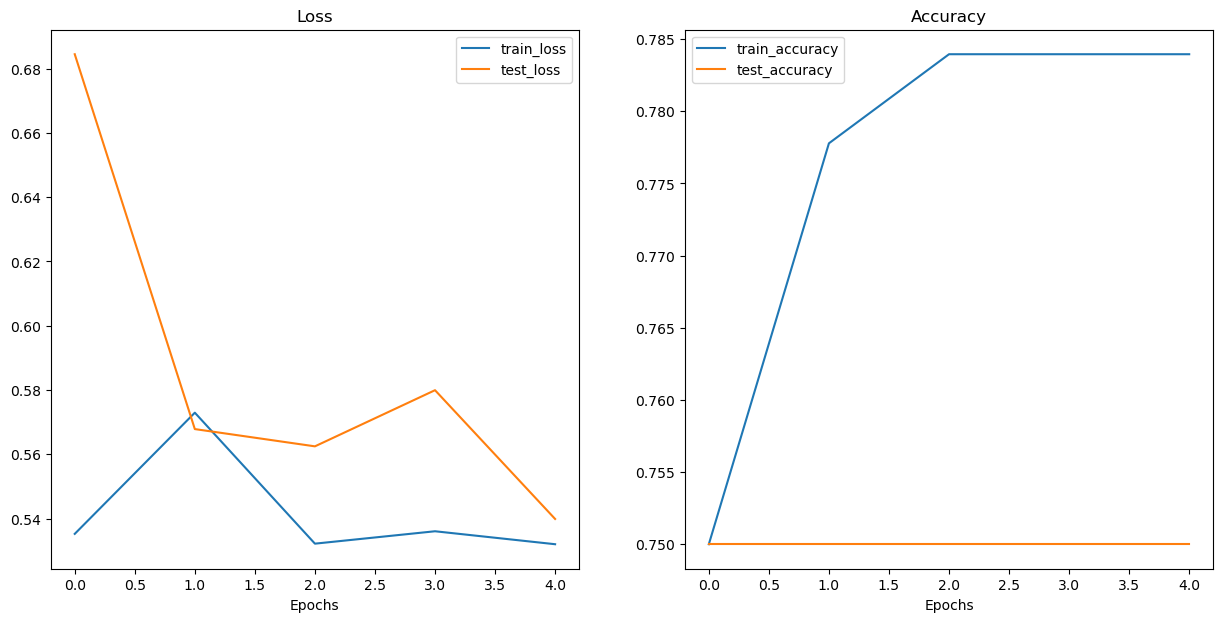

In [2]:
import matplotlib.pyplot as plt
print(model_0_results.keys())

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
        
plot_loss_curves(model_0_results)

In [4]:
import torch
torch.tensor([0])
onehot = torch.nn.functional.one_hot(torch.tensor([0]), num_classes=2)
print(onehot)


tensor([[1, 0]])
